In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
DATA = np.loadtxt(r'C:\Users\au581149\PhD-Work\Lab Stuff\ESI\Mass Selection\MathieuMapCOARSE4.txt',skiprows = 2, delimiter = ',')

UDCs = DATA[:,3]
VRFs = DATA[:,4]
Counts = DATA[:,1]





UniqueRFs = np.unique(VRFs)
UniqueDCs = np.unique(UDCs)
DATAGrid = np.zeros((len(UniqueDCs),len(UniqueRFs)))
DATAGridNorm = np.zeros((len(UniqueDCs),len(UniqueRFs)))
print(np.shape(DATAGrid))
for j,VRF in enumerate(UniqueRFs):
    for m,DC in enumerate(UniqueDCs):
        signal = np.sum(Counts[np.bitwise_and(UDCs == DC,VRFs == VRF)])
        DATAGrid[m,j] = signal
        DATAGridNorm[m,j] = signal
    DATAGridNorm[:,j] /= np.max(DATAGridNorm[:,j])

    
# print(UniqueRFs)

(20, 80)


In [95]:
#Create the matrix as defined by Uehara:
def detMuVECTa(a_s,q,kappa,tol = 1e-3,mu = 0):
    #Approximate Delta(mu) as defined by Hasegawa & Uehara
    #
    # PARAMETERS
    # a - a value for trapping
    # q - q value for trapping
    # kappa - friction term, see Hasegawa & Uehara for further details
    # tol - relative tolerance at which to stop calculating
    

    res = []
    for a in a_s:
        currentS = 1
        nextS = 2
        currentMatrix = makeMatrix(a,q,kappa,currentS)
        nextMatrix = makeMatrix(a,q,kappa,nextS)
        rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
        while np.abs(rel_diff) > tol:
            nextS +=1
            currentS +=1
            currentMatrix = makeMatrix(a,q,kappa,currentS,mu)
            nextMatrix = makeMatrix(a,q,kappa,nextS,mu)
            rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
            res.append(np.linalg.det(currentMatrix))
    return np.array(res)


def chi(a,q,kappa,s,mu = 0):
    #
    # PARAMETERS
    # a - a value for the trap
    # q - q value for the trap
    # kappa - friction term, see Hasegawa & Uehara for further details
    # s - integer number for which chi is defined
    # mu - complex number
    #
    #
    # RETURN
    # chi - chi_s(a,q,kappa)  as defined by Hasegawa & Uehara
    return q/((2*s-1j*mu)**2 -a + kappa**2)
    #return s


def makeMatrix(a,q,kappa,S_max, mu= 0):
    #
    # PARAMETERS
    # a - a value for trapping
    # q - q value for trapping
    # kappa - friction term, see Hasegawa & Uehara for further details
    # S_max - max value for which to compute chi_s matrix
    # 
    # RETURN
    # tridiagonal matrix as defined by Hasegawa & Uehara of dimension 2*S_max + 1
    matrix = np.identity(2*S_max+1,dtype = np.complex128)
    length = matrix.shape[0]
    matrix[0,1] = chi(a,q,kappa,-S_max)
    matrix[length-1,length-2] = chi(a,q,kappa,S_max)
    for j in range(1,length-1):
        s = j-S_max
        matrix[j,j+1] = chi(a,q,kappa,s,mu)
        matrix[j,j-1] = chi(a,q,kappa,-s,mu)
    return matrix

def detMu(a,q,kappa,tol = 1e-3,mu = 0):
    #Approximate Delta(mu) as defined by Hasegawa & Uehara
    #
    # PARAMETERS
    # a - a value for trapping
    # q - q value for trapping
    # kappa - friction term, see Hasegawa & Uehara for further details
    # tol - relative tolerance at which to stop calculating
    
    
    currentS = 1
    nextS = 2
    currentMatrix = makeMatrix(a,q,kappa,currentS)
    nextMatrix = makeMatrix(a,q,kappa,nextS)
    rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
    while np.abs(rel_diff) > tol:
        nextS +=1
        currentS +=1
        currentMatrix = makeMatrix(a,q,kappa,currentS,mu)
        nextMatrix = makeMatrix(a,q,kappa,nextS,mu)
        rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
    return np.linalg.det(currentMatrix)#, currentS

def isStable(a,q,kappa, tol = 1e-3):
    detVal = detMu(a,q,kappa,tol)
    checkValue = detVal*(np.sin(np.pi/2 * np.sqrt(a-kappa**2,dtype = np.complex128)))**2
    if checkValue > 1: ###CASE 1
        alpha = 2/np.pi * np.arccosh(np.sqrt(checkValue,dtype = np.complex128))
        if alpha <= kappa:
            return True
        else:
            return False
    elif checkValue >= 0: ###CASE 2
        return True 
    else: ###CASE 3
        alpha = 2/np.pi * np.arcsinh(np.sqrt(-checkValue,dtype = np.complex128))
        if alpha <= kappa:
            return True
        else:
            return False


def makeStabilityDiagram(a_array,q_array,kappa,tol = 1e-3):
    # 
    # PARAMETERS
    # a - array of a values for which to determine stability over
    # q - array of q values over which to determine stability over
    # kappa- friction term, see Hasegawa & Uehara for further details
    

    top_a = []
    top_q = []
    bottom_a = []
    bottom_q = []
    for idx,q in enumerate(q_array):
        #print(rf'At index {idx} out of {len(q_array)}')
        #Bottom Line
        for a in a_array:
            if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                bottom_a.append(a)
                bottom_q.append(q)
                break
        #Top Line
        for a in np.flip(a_array):
            if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                top_a.append(a)
                top_q.append(q)
                break
    return [np.array(top_a),np.array(top_q),np.array(bottom_a),np.array(bottom_q)]
#print(detMu(0,0.5,0.002)[0])

def makeStabilityDiagramDEVELOP(a_array,q_array,kappa,N = 100,tol = 1e-3):
    # 
    # PARAMETERS
    # a - array of a values for which to determine stability over
    # q - array of q values over which to determine stability over
    # kappa- friction term, see Hasegawa & Uehara for further details
    

    top_a = []
    top_q = []
    bottom_a = []
    bottom_q = []
    for idx,q in enumerate(q_array):
        #print(rf'At index {idx} out of {len(q_array)}')
        #Bottom Line
        if not top_a:
            for a in a_array:
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    bottom_a.append(a)
                    bottom_q.append(q)
                    print(a,q)
                    break
                #Top Line
            for a in np.flip(a_array):
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    top_a.append(a)
                    top_q.append(q)
                    break   
        else:
            search_A_down_from = top_a[-1]+0.1
            search_A_up_from = bottom_a[-1]-0.1
            for a in np.linspace(search_A_up_from,bottom_a[-1]+0.1,N):
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    bottom_a.append(a)
                    bottom_q.append(q)
                    break
            for a in np.flip(np.linspace(top_a[-1]-0.1,search_A_down_from,N)):
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    top_a.append(a)
                    top_q.append(q)
                    break
    return [top_a,top_q,bottom_a,bottom_q]

def rootFinderStability(q,k):
    def alpha(a):
        CheckValue = detMuVECTa(a,q,k)*np.sin(np.pi/2*np.sqrt(a-k**2))**2
        if CheckValue > 1:
            return np.real(2/np.pi/(np.arccosh(np.sqrt(CheckValue)))-k)
        elif CheckValue > 0:
            return np.real(0-k)
        else:
            return np.real(2/np.pi/(np.arcsinh(np.sqrt(-CheckValue)))-k)
    return root(alpha,x0 = 0)



def upper_a(q,kappa):
    for a in np.flip(np.linspace(-0.5,0.5,500)):
        if np.bitwise_and(isStable(a,q,kappa),isStable(-0.5*a,-0.5*q,kappa)):
            break
    return a
def lower_a(q,kappa):
    for a in np.linspace(-0.5,0.5,500):
        if np.bitwise_and(isStable(a,q,kappa),isStable(-0.5*a,-0.5*q,kappa)):
            break
    return a

def upper_a_VECTORIZED(qs,kappa):
    result = []
    for q in qs:
        result.append(upper_a(q,kappa))
    return np.array(result)

def DC_to_az(DC,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return -16*elementary_charge*DC/(omega**2*zeta2*m_to_z*amu)
def RF_to_qz(RF,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return 8*elementary_charge*RF/(omega**2*zeta2*m_to_z*amu)
def az_to_DC(a,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return a/(-16*elementary_charge/(omega**2*zeta2*m_to_z*amu))
def qz_to_RF(q,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return q/(8*elementary_charge/(omega**2*zeta2*m_to_z*amu))



def DC_to_azp(DC):
    return DC_to_az(DC,443,2*np.pi*300*1e3,2.36*1e-4)
def RF_to_qzp(RF):
    return RF_to_qz(RF,443,2*np.pi*300*1e3,2.36*1e-4)
def az_to_DCp(a):
    return az_to_DC(a,443,2*np.pi*300*1e3,2.36*1e-4)
def qz_to_RFp(q):
    return qz_to_RF(q,443,2*np.pi*300*1e3,2.36*1e-4)

def makeStabilityTop(a_array,q_array,kappa, tol = 1e-3):
    top_a = []
    top_q = []
    for q in q_array:
        for a in np.flip(a_array):
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    top_a.append(a)
                    top_q.append(q)
                    break
    return [np.array(top_a),np.array(top_q)]

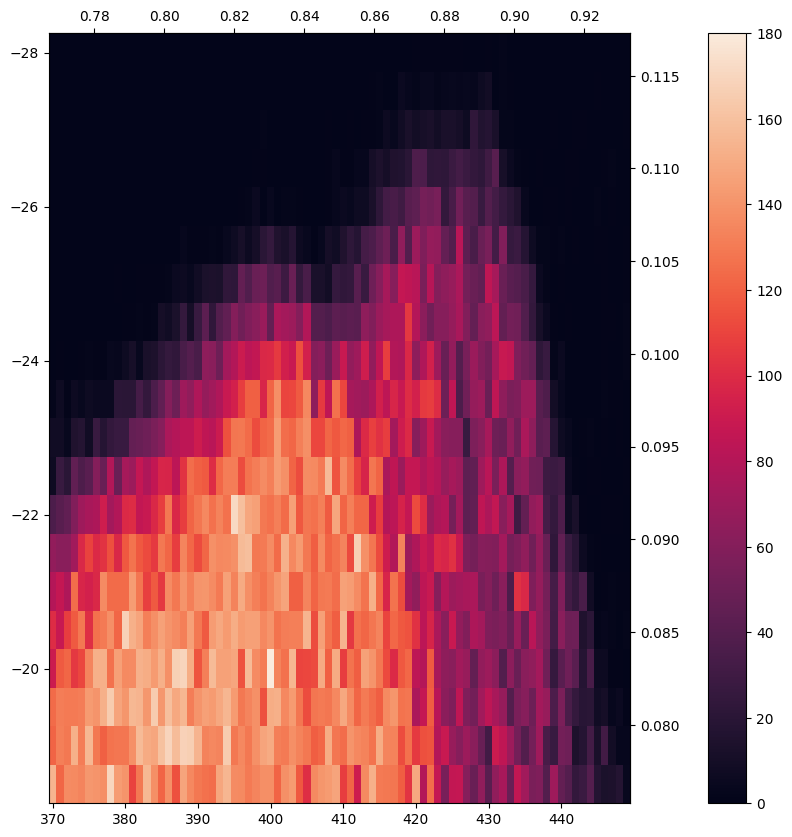

In [96]:
f1,ax1 = plt.subplots(figsize = (10,10))

p1 = ax1.pcolormesh(UniqueRFs,UniqueDCs-23,DATAGrid,cmap = 'rocket')
ax1.invert_yaxis()
f1.colorbar(p1,pad = 0.1)
x1 = ax1.secondary_xaxis(location = 'top',functions = (RF_to_qzp,qz_to_RFp))
y2 = ax1.secondary_yaxis(location = 'right',functions = (DC_to_azp,az_to_DCp))


In [98]:
a_array = np.linspace(0,0.3,500)
q_array = np.linspace(0.6,1,500)

topA,topQ = makeStabilityTop(a_array,q_array,0)

C:\Users\au581149\AppData\Local\Temp\ipykernel_20744\3850623175.py:41: RuntimeWarning: divide by zero encountered in divide
  return q/((2*s-1j*mu)**2 -a + kappa**2)
C:\Users\au581149\AppData\Local\Temp\ipykernel_20744\3850623175.py:41: RuntimeWarning: invalid value encountered in divide
  return q/((2*s-1j*mu)**2 -a + kappa**2)
c:\Users\au581149\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\au581149\AppData\Local\Temp\ipykernel_20744\3850623175.py:79: RuntimeWarning: invalid value encountered in scalar divide
  rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)


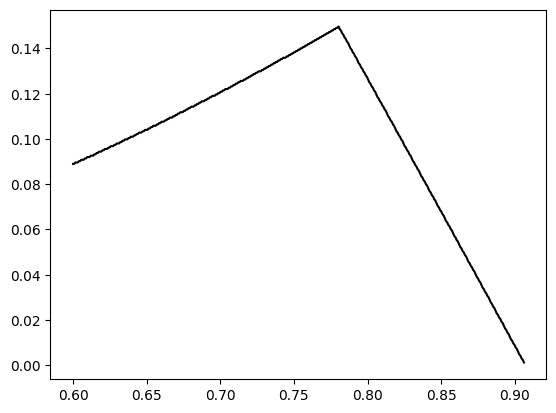

In [99]:
figStab,axStab = plt.subplots()
axStab.plot(topQ,topA, 'k')


Text(0, 0.5, 'a parameter')

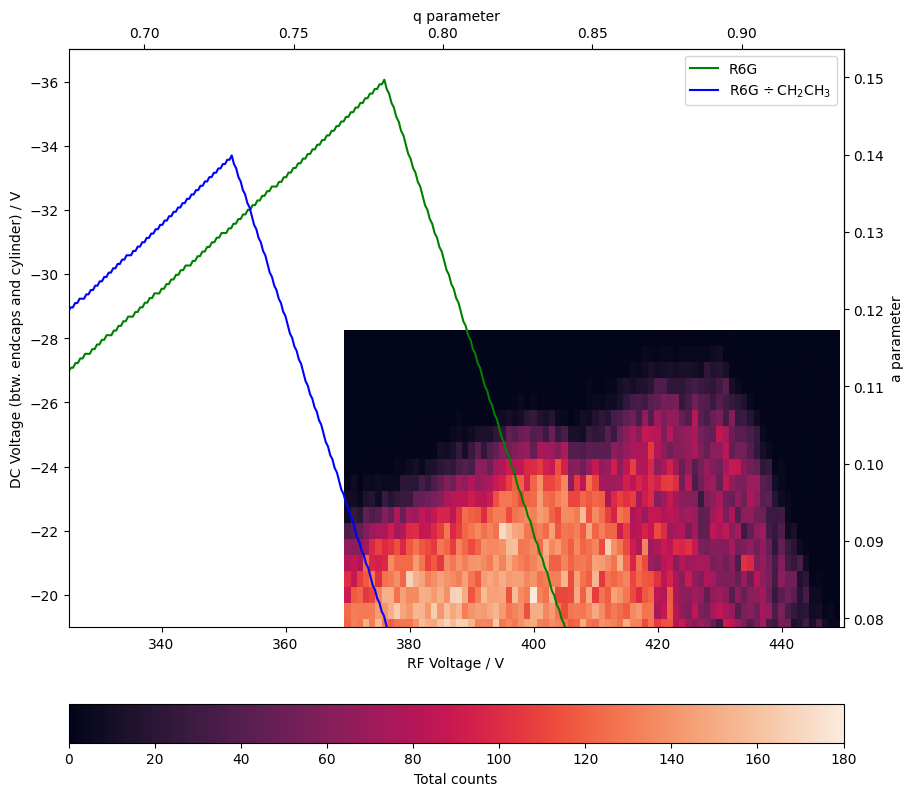

In [121]:
omega = 2*np.pi*300*1e3
zeta2 = 2.36*1e-4


f1,ax1 = plt.subplots(figsize = (10,10))

p1 = ax1.pcolormesh(UniqueRFs,UniqueDCs-23,DATAGrid,cmap = 'rocket')
ax1.invert_yaxis()
c1 = f1.colorbar(p1,pad = 0.1,location = 'bottom')
c1.set_label('Total counts')
x1 = ax1.secondary_xaxis(location = 'top',functions = (RF_to_qzp,qz_to_RFp))
y1 = ax1.secondary_yaxis(location = 'right',functions = (DC_to_azp,az_to_DCp))


ax1.plot(qz_to_RF(topQ,443,omega,zeta2),az_to_DC(topA,443,omega,zeta2),'g',label = 'R6G')
# ax1.plot(qz_to_RF(bottomQ,443,omega,zeta2),az_to_DC(bottomA,443,omega,zeta2),'g')

ax1.plot(qz_to_RF(topQ,443-29,omega,zeta2),az_to_DC(topA,443-29,omega,zeta2),'b', label = r'R6G $\div \, \mathrm{CH_2CH_3}$')
# ax1.plot(qz_to_RF(bottomQ,443-29,omega,zeta2),az_to_DC(bottomA,443-29,omega,zeta2),'b')


ax1.set_xlim(325,450)
ax1.set_ylim(-19,-37)

idxMaxFragment = np.argmin(az_to_DC(topA,443-29,omega,zeta2))
idxMaxR6G = np.argmin(az_to_DC(topA,443,omega,zeta2))
# ax1.axvline(qz_to_RF(topQ,443-29,omega,zeta2)[idxMaxFragment],color = 'b', ls = '--')
# ax1.axvline(qz_to_RF(topQ,443,omega,zeta2)[idxMaxR6G],color = 'g', ls = '--')

ax1.legend()

ax1.set_xlabel('RF Voltage / V')
ax1.set_ylabel('DC Voltage (btw. endcaps and cylinder) / V')

x1.set_xlabel('q parameter')
y1.set_ylabel('a parameter')